# Exercise 6

## Predict rating using LSTM


In [1]:
import pandas as pd

In [2]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [18]:
dataTraining.shape

(7895, 6)

In [4]:
plots = dataTraining['plot']
#Devuelve 1 o 0 comparando columna 'rating' con su media para cada elemento indicando: (1) mayor o igual que la media y (0) menor que media.
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [5]:
plots

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [6]:
y

3107    1
900     0
6724    1
4704    1
2582    1
       ..
8417    0
1592    0
1723    0
7605    1
215     1
Name: rating, Length: 7895, dtype: int32

# Exercise 6.1

- Remove stopwords
- Lowercase
- split the text in words
- pad_sequences

In [32]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Corregido
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.inputs.keras import PlotLossesCallback  
from tensorflow.keras.optimizers import RMSprop,Adam

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stopwords_en = set(stopwords.words('english')).union({"is", "the", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"})

In [10]:
def preprocesamiento_optimizado(text):
    # Convertir a minúsculas y quitar caracteres no alfabéticos
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    # Eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords_en])
    return text

In [11]:
#Se ejecuta función de Preprocesamiento sobre plot
dataTraining['plot_ppr'] = dataTraining['plot'].apply(preprocesamiento_optimizado)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataTraining['plot_ppr'])
vocab_size = len(tokenizer.word_index) + 1

In [13]:
# Convertir texto a secuencia de enteros
X_seq = tokenizer.texts_to_sequences(dataTraining['plot_ppr'])

In [14]:
# Longitud máxima encontrada en el dataset
max_len = max(len(x) for x in X_seq)

In [15]:
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [19]:
# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.25, random_state=1306)

# Exercise 6.2

Create a SimpleRNN neural network to predict the rating of a movie

Calculate the testing set accuracy

In [22]:
model_RNN_optimized = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    Dropout(0.5),
    SimpleRNN(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Usar 'sigmoid' para clasificación binaria
])
# Compilar el modelo
model_RNN_optimized.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_RNN_optimized.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 820, 64)           2465024   
                                                                 
 dropout_2 (Dropout)         (None, 820, 64)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,468,161
Trainable params: 2,468,161
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Entrenar el modelo
batch_size = 128
epochs = 20

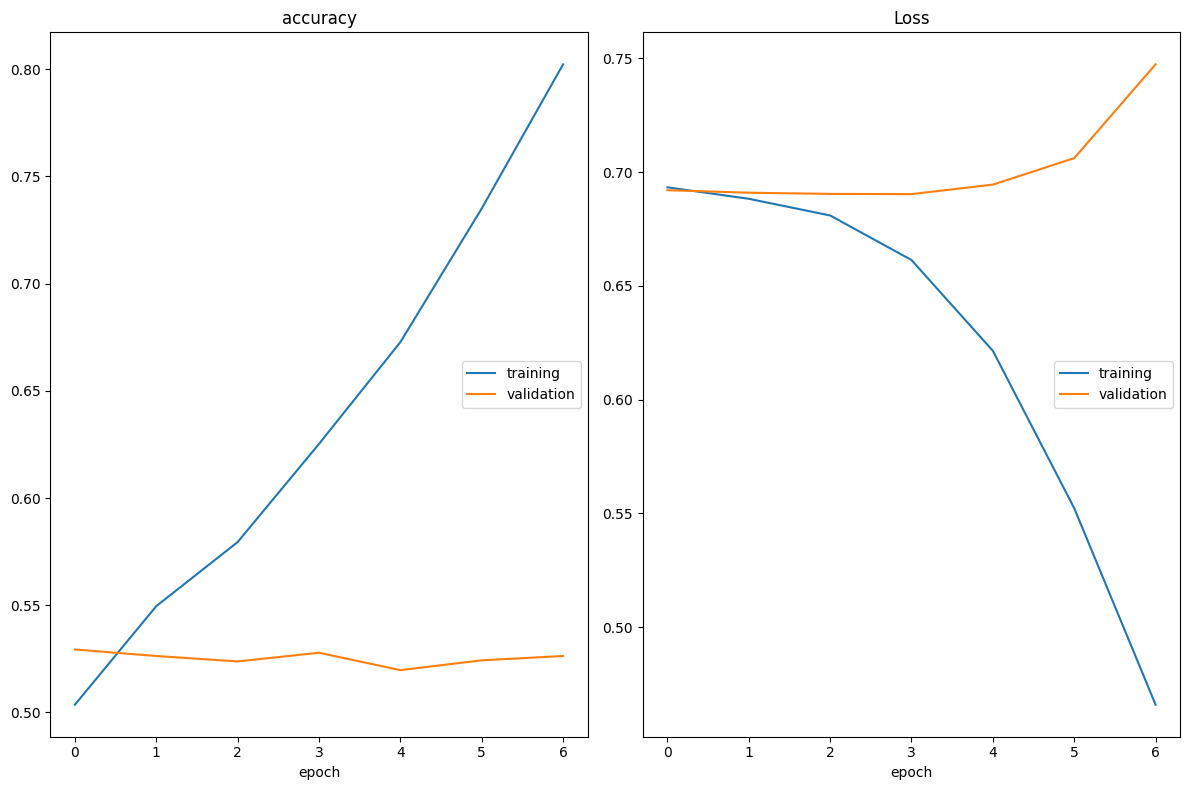

accuracy
	training         	 (min:    0.504, max:    0.802, cur:    0.802)
	validation       	 (min:    0.520, max:    0.529, cur:    0.526)
Loss
	training         	 (min:    0.466, max:    0.693, cur:    0.466)
	validation       	 (min:    0.690, max:    0.747, cur:    0.747)
47/47 [==============================] - 11s 228ms/step - loss: 0.4659 - accuracy: 0.8022 - val_loss: 0.7474 - val_accuracy: 0.5263


In [24]:
# Implementar Early Stopping para evitar el sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_RNN_optimized.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[PlotLossesCallback(), early_stopping]  # Actualizado para la sintaxis correcta
)

In [25]:
# Calcular la precisión en el conjunto de prueba
test_loss, test_accuracy_RNN = model_RNN_optimized.evaluate(X_test, y_test)
print("Loss en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy_RNN)

62/62 [==============================] - 2s 38ms/step - loss: 0.6904 - accuracy: 0.5279
Loss en el conjunto de prueba: 0.6903874278068542
Precisión en el conjunto de prueba: 0.5278621912002563


# Exercise 6.3

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [28]:
model_LSTM_optimized = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    Dropout(0.5),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model_LSTM_optimized.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_LSTM_optimized.summary()

#USAMOS LOS MISMOS DATOS DE ENTRENAMIENTO DEL MODELO ANTERIOR

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 820, 64)           2465024   
                                                                 
 dropout_5 (Dropout)         (None, 820, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,477,473
Trainable params: 2,477,473
Non-trainable params: 0
_________________________________________________________________


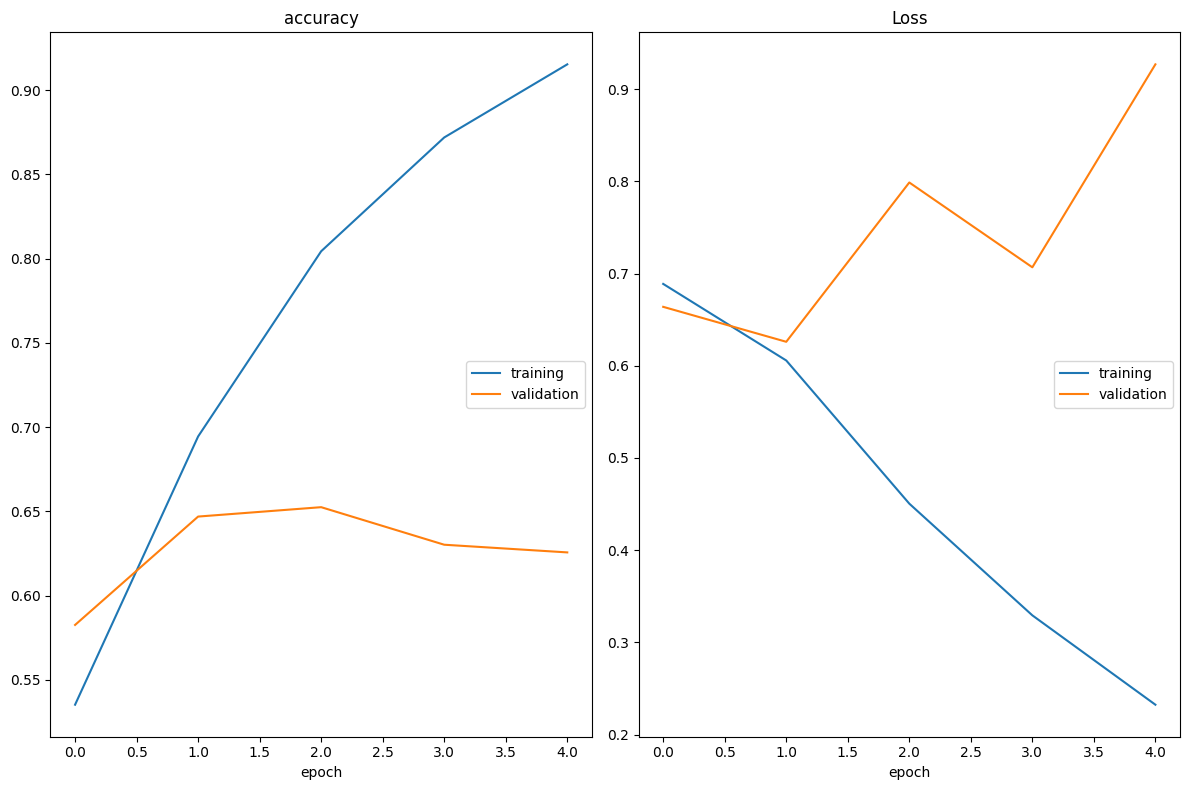

accuracy
	training         	 (min:    0.535, max:    0.915, cur:    0.915)
	validation       	 (min:    0.583, max:    0.652, cur:    0.626)
Loss
	training         	 (min:    0.232, max:    0.689, cur:    0.232)
	validation       	 (min:    0.626, max:    0.927, cur:    0.927)
47/47 [==============================] - 21s 450ms/step - loss: 0.2324 - accuracy: 0.9154 - val_loss: 0.9270 - val_accuracy: 0.6256


In [29]:
# Implementar Early Stopping para evitar el sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_LSTM_optimized.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[PlotLossesCallback(), early_stopping]  # Actualizado para la sintaxis correcta
)

In [30]:
# Calcular la precisión en el conjunto de prueba
test_loss, test_accuracy_LSTM = model_LSTM_optimized.evaluate(X_test, y_test)

print("Loss en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy_LSTM)

62/62 [==============================] - 4s 58ms/step - loss: 0.6260 - accuracy: 0.6469
Loss en el conjunto de prueba: 0.6260432004928589
Precisión en el conjunto de prueba: 0.6469098329544067


# Exercise 6.4

Create a GRU neural network to predict the rating of a movie

Calculate the testing set accuracy

In [33]:
model_GRU_optimized = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len),  # Ajustar output_dim a 100 es común y eficiente
    Dropout(0.5),  # Mantener el Dropout para reducir el sobreajuste
    GRU(32),  # Utilizar 32 unidades en la capa GRU es un buen punto de partida
    Dense(1, activation='sigmoid')  # Usar 'sigmoid' para clasificación binaria
])

# Compilar el modelo
model_GRU_optimized.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_GRU_optimized.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 820, 100)          3851600   
                                                                 
 dropout_6 (Dropout)         (None, 820, 100)          0         
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,864,497
Trainable params: 3,864,497
Non-trainable params: 0
_________________________________________________________________


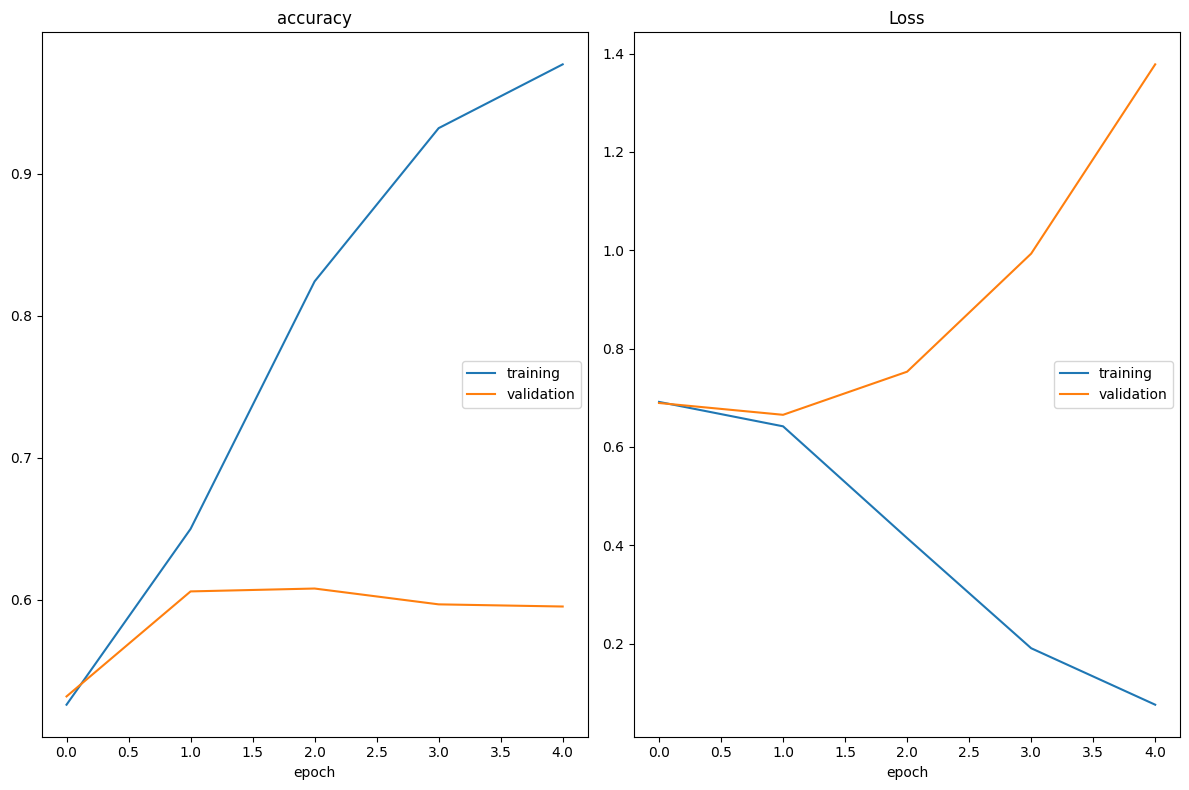

accuracy
	training         	 (min:    0.526, max:    0.977, cur:    0.977)
	validation       	 (min:    0.532, max:    0.608, cur:    0.595)
Loss
	training         	 (min:    0.075, max:    0.691, cur:    0.075)
	validation       	 (min:    0.665, max:    1.378, cur:    1.378)
47/47 [==============================] - 30s 643ms/step - loss: 0.0755 - accuracy: 0.9770 - val_loss: 1.3781 - val_accuracy: 0.5952


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_GRU_optimized.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[PlotLossesCallback(), early_stopping]  # Usar PlotLossesCallback para monitorear el entrenamiento
)

In [35]:
test_loss, test_accuracy_GRU = model_GRU_optimized.evaluate(X_test, y_test)

print("Loss en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy_GRU)

62/62 [==============================] - 3s 53ms/step - loss: 0.6652 - accuracy: 0.6059
Loss en el conjunto de prueba: 0.6652173399925232
Precisión en el conjunto de prueba: 0.6058763861656189


#Comparación Modelos

In [36]:
#Comparación Accuracy de Modelos en Test
print('Datos Test RNN  ->  ',test_accuracy_RNN)  #Accuracy RNN
print('Datos Test LSTM ->  ',test_accuracy_LSTM) #Accuracy LSTM
print('Datos Test GRU  ->  ',test_accuracy_GRU)  #Accuracy GRU

Datos Test RNN  ->   0.5278621912002563
Datos Test LSTM ->   0.6469098329544067
Datos Test GRU  ->   0.6058763861656189
